# Definición de los modelos.

Debido a que el notebook está hecho en Google Collab, las imágenes están guardadas en Google Drive, primero es necesario ubicarnos en el folder correspondiente donde están todas nuestras imágenes.

In [ ]:
%cd drive/MyDrive/Sprite_refri

/content/drive/.shortcut-targets-by-id/1-jD7WLMdUgZYVERC_Q9SBlSQEm5HyziM/Sprite_refri


Se hacen los imports necesarios para que el código funcione.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

Se definen constantes.

In [ ]:
VAL_ACCURACY = [] #Lista con todos los accuracys de cada fold
MODELS = []  #Lista con todos los modelos
EPOCHS = []  #Lista con el número de épocas para cada modelo
train_data_dir = os.getcwd() + '/train'  #Directorio de los datos de entrenamiento
val_data_dir = os.getcwd() + '/validation'  #Directorio de los datos de validación
img_height = 224  #Altura de las imágenes
img_width = 224  #Ancho de las imágenes
batch_size = 32  #Tamaño del batch
CLASSES = 21  #Número de clases (SKUs)
AUTOTUNE = tf.data.AUTOTUNE 

Para fines de demostración, se define inicialmente el primer modelo a utilizar (un modelo hecho a mano) de la siguiente manera:

In [ ]:
#Se crea una capa de normalización y de data augmentation
normalization_layer = layers.Rescaling(1./255)

data_augmentation = keras.Sequential(
  [
    #Se agrega un random flip, rotation y zoom
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#Se crea el modelo con sus capas convolutivas, de dropout y densas
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(CLASSES)
])

Inicialmente se ocupó una capa densa con menos neuronas y no se utilizó una capa de dropout, sin embargo estos dos factores se cambiaron lo cual hizo que mejorara la presición y el presupuesto del modelo.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

Este modelo es relativamente sencillo ya que contiene una cantidad moderada de parámetros para entrenar.

# Preprocesamiento de los datos.

Debido a que la función image_dataset_from_directory no es compatible con los k-folds será necesario crear un .csv que almacene el path original de cada imagen junto con sus etiquetas para cambiar los datasets cada fold.

In [ ]:
main_directory = os.listdir('train')

with open('products.csv', 'w', encoding='utf-8') as file:
  file.write('filename,label\n')
  #Se itera sobre cada folder del directorio principal (cada directorio representa una clase)
  for folder in main_directory:
    folder_path = os.getcwd() + '/train/' + folder
    folder_directory = os.listdir(folder_path)
    for image in folder_directory:
      #Se itera sobre cada imagen de cada sub-directorio y se escribe su path y label en el .csv
      image_path = folder_path + '/' + image
      file.write(image_path + ',' + folder + '\n')
file.close()

Posterior a esto se crea un dataset con este .csv para facilitar el acceso a la información.

In [ ]:
data = pd.read_csv('products.csv')
data

,filename,label
0,/content/drive/.shortcut-targets-by-id/1-jD7WL...,powerade_lata
1,/content/drive/.shortcut-targets-by-id/1-jD7WL...,powerade_lata
2,/content/drive/.shortcut-targets-by-id/1-jD7WL...,powerade_lata
3,/content/drive/.shortcut-targets-by-id/1-jD7WL...,powerade_lata
4,/content/drive/.shortcut-targets-by-id/1-jD7WL...,powerade_lata
...,...,...
331,/content/drive/.shortcut-targets-by-id/1-jD7WL...,sprite_600ml
332,/content/drive/.shortcut-targets-by-id/1-jD7WL...,sprite_600ml
333,/content/drive/.shortcut-targets-by-id/1-jD7WL...,sprite_600ml
334,/content/drive/.shortcut-targets-by-id/1-jD7WL...,sprite_600ml


Se crea una columna Y que contiene todos los labels, esta se ocupará para iterar sobre los folds.

In [ ]:
Y = data[['label']]
Y

,label
0,powerade_lata
1,powerade_lata
2,powerade_lata
3,powerade_lata
4,powerade_lata
...,...
331,sprite_600ml
332,sprite_600ml
333,sprite_600ml
334,sprite_600ml


# Preparando el K-Fold.

Se crea un Stratified KFold de 10 folds para maximizar las probabilidades de que toque al menos un elemento de cada clase.

In [ ]:
k_fold = StratifiedKFold(n_splits=10, random_state=69, shuffle=True)

Se genera la variable n que contiene el total de imágenes que se ocuparán.

In [ ]:
n  = data.count()['filename']

Ahora, se crea un directorio llamado validation el cual almacenará todos los datos de validación, debido a que necesita tener la misma estructura que el directorio de pruebas se entrará a este mismo folder y se iterará para crear cada uno de los folders que representan a cada clase.

In [ ]:
os.mkdir('validation')

In [ ]:
%cd validation

/content/drive/.shortcut-targets-by-id/1-jD7WLMdUgZYVERC_Q9SBlSQEm5HyziM/Sprite_refri/validation


In [ ]:
for folder in main_directory:
  os.mkdir(folder)

Finalmente volvemos a colocarnos en el directorio raíz.

In [ ]:
%cd ..

/content/drive/.shortcut-targets-by-id/1-jD7WLMdUgZYVERC_Q9SBlSQEm5HyziM/Sprite_refri


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1-jD7WLMdUgZYVERC_Q9SBlSQEm5HyziM/Sprite_refri


# Visualización de las clases.

Se genera un dataset temporal únicamente para visualizar todas as clases disponibles.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds.class_names

Found 336 files belonging to 21 classes.
Using 269 files for training.


['Coca 600ml',
 'Del valle mango',
 'Del valle manzana',
 'Fresca',
 'Fuze tea durazno',
 'Manzanita',
 'Powerade rojo',
 'Sprite lata',
 'ciel_600ml',
 'ciel_mineral_600ml',
 'coca_cola_lata',
 'coca_cola_light_600ml',
 'fanta_600ml',
 'fanta_lata',
 'fuze_tea_limon_blanco_600ml',
 'limon_y_nada_600ml',
 'naranja_y_nada_600ml',
 'powerade_azul_600ml',
 'powerade_lata',
 'santa_clara_250ml',
 'sprite_600ml']

# Entrenamiento del primer modelo.

Ahora se procede a entrenar el modelo usando los 10 folds.

In [ ]:
#Se entrenará el modelo 20 épocas en cada fold
epochs=20

for i, (train_index, val_index) in enumerate(k_fold.split(np.zeros(n), Y)):
  #Se obtienen los índices de los datos que se usarán para entenar y validar
  train_data = data.iloc[train_index]
  val_data = data.iloc[val_index]

  new_paths = []

  for val_file in val_data[['filename']].values:
    #Se itera sobre los datos de validación y se les asignan nuevos paths para moverlos a la carpeta de validación
    new_path = os.getcwd() + '/validation/' + val_file[0].split('/')[-2]
    shutil.move(val_file[0], new_path)
    new_paths.append(new_path + '/' + val_file[0].split('/')[-1])
  
  #Se crean ambos datasets usando sus carpetas correspondientes
  train_dataset = tf.keras.utils.image_dataset_from_directory(
      train_data_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
      )
  val_dataset = tf.keras.utils.image_dataset_from_directory(
      val_data_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
      )
  
  #Se optimizan los datasets para acelerar el entrenamiento
  train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  
  #Se vuelve a definir el modelo para que sea entrenado siempre desde 0
  model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(CLASSES)
  ])

  #Se compila usando Adam, sparse categorical crossentropy y se recopila su accuracy
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  #Se crea un early stopping para evitar que se entrene de más innecesariamente
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=10, restore_best_weights=True)
  
  #Se entrena el modelo
  history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=[callback])
  
  #Se obtiene el accuracy del modelo entrenado
  score = model.evaluate(val_dataset)[1]
  VAL_ACCURACY.append(score)

  MODELS.append(model)
  EPOCHS.append(history.epoch[-1])

  print(f'Fold {i + 1} accuracy: {score}')

  for val_file in new_paths:
    #Se regresan las imágenes a sus folders originales
    new_path = os.getcwd() + '/train/' + val_file.split('/')[-2]
    shutil.move(val_file, new_path)

print(f'The model has an overall accuracy of {np.average(VAL_ACCURACY)} +/- {np.std(VAL_ACCURACY)}')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Found 302 files belonging to 21 classes.
Found 34 files belonging to 21 classes.
Epoch 1/20
10/10 [==============================] - 99s 1s/step - loss: 3.5453 - accuracy: 0.1523 - val_loss: 2.8362 - val_accuracy: 0.1765
Epoch 2/20
10/10 [==============================] - 1s 59ms/step - loss: 2.4945 - accuracy: 0.2715 - val_loss: 1.9593 - val_accuracy: 0.4412
Epoch 3/20
10/10 [==============================] - 1s 54ms/step - loss: 1.7979 - accuracy: 0.4801 - val_loss: 1.2111 - val_accuracy: 0.5588
Epoch 4/20
10/10 [==============================] - 1s 57ms/step - loss: 0.8859 - accuracy: 0.7616 - val_loss: 0.6644 - val_accuracy: 0.8235
Epoch 5/20
10/10 [==============================] - 1s 53ms/step - loss: 0.5302 - accuracy: 0.8146 - val_loss: 0.4068 - val_accuracy: 0.8529
Epoch 6/20
10/10 [==============================] - 1s 54ms/step - loss: 0.2680 - accuracy: 0.9205 - val_loss: 0.1765 - val_accuracy: 0.9412
Epoch 7/20
10/10 [==============================] - 1s 57ms/step - loss: 0

Ahora se plotea la precisión de cada modelo de cada fold.

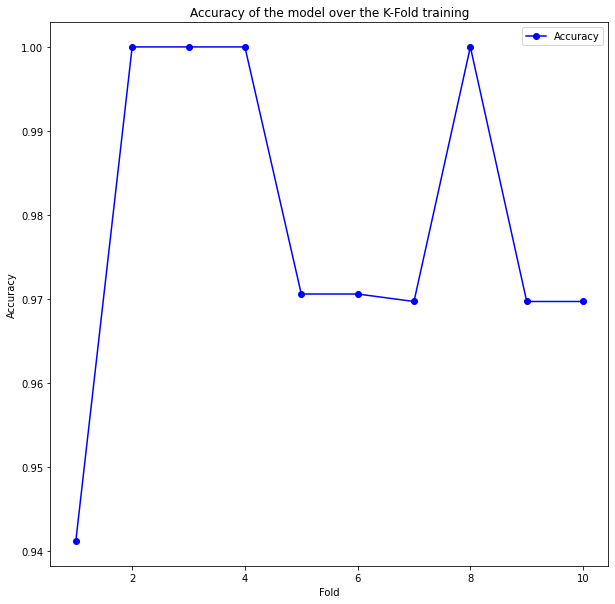

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(1, 11), VAL_ACCURACY, 'b-o', label='Accuracy')
plt.legend(loc='upper right')
plt.title('Accuracy of the model over the K-Fold training')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

También se plotean las épocas que le tomó a cada modelo converger.

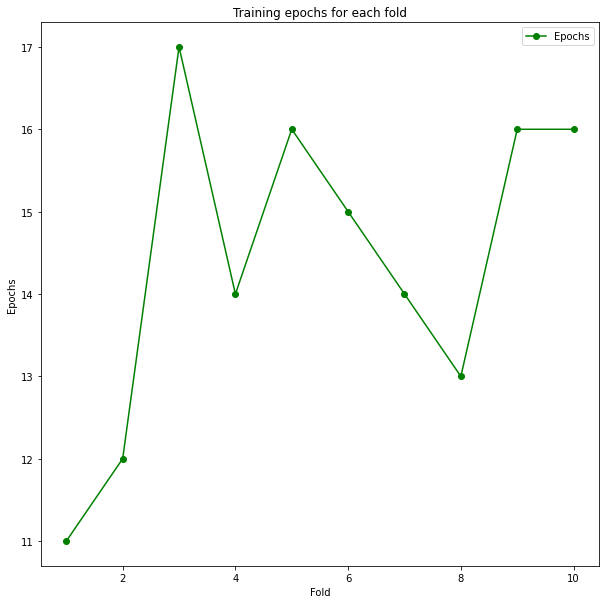

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, 11), EPOCHS, 'g-o', label='Epochs')
plt.legend(loc='upper right')
plt.title('Training epochs for each fold')
plt.xlabel('Fold')
plt.ylabel('Epochs')
plt.show()

## Guardando el modelo.

Nos ubicamos en la carpeta correspondiente para guardar el modelo.

In [ ]:
%cd ..
%cd ..
%cd ..

/content/drive/.shortcut-targets-by-id/1-jD7WLMdUgZYVERC_Q9SBlSQEm5HyziM
/content/drive/.shortcut-targets-by-id
/content/drive


In [ ]:
%cd MyDrive/SKUs/Modelo\ Isra/model/IS model

/content/drive/MyDrive/SKUs/Modelo Isra/model/IS model


Se obtiene el último modelo con mejor desempeño.

In [ ]:
#Cambiar dependiendo de la primer gráfica
model_2_save = MODELS[7]
model_2_save.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

In [ ]:
#Cambiar el nombre basándose en el número de skus a predecir
model_2_save.save('IS_model_21skus_new')

Volvemos a ubicarnos en el folder de datos para entrenar el siguiente modelo.

In [ ]:
%cd ..
%cd .. 
%cd .. 
%cd ..

/content/drive/MyDrive/SKUs/Modelo Isra/model
/content/drive/MyDrive/SKUs/Modelo Isra
/content/drive/MyDrive/SKUs
/content/drive/MyDrive


In [ ]:
%cd Sprite_refri

/content/drive/.shortcut-targets-by-id/1-jD7WLMdUgZYVERC_Q9SBlSQEm5HyziM/Sprite_refri


# Entrenando el segundo modelo.

Se sigue el mismo procedimiento para el segundo modelo, se entrena por caqda fold, cambiando las imagenes a la carpeta de validación y entrenamiento según el fold, se generan sus respectivas gráficas y finalmente se guarda el modelo con mejor desempeño.

In [ ]:
MODELS = []
VAL_ACCURACY = []
EPOCHS = []

for i, (train_index, val_index) in enumerate(k_fold.split(np.zeros(n), Y)):
  train_data = data.iloc[train_index]
  val_data = data.iloc[val_index]

  new_paths = []

  for val_file in val_data[['filename']].values:
    new_path = os.getcwd() + '/validation/' + val_file[0].split('/')[-2]
    shutil.move(val_file[0], new_path)
    new_paths.append(new_path + '/' + val_file[0].split('/')[-1])
  
  train_dataset = tf.keras.utils.image_dataset_from_directory(
      train_data_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
      )
  val_dataset = tf.keras.utils.image_dataset_from_directory(
      val_data_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size
      )
  
  train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  
  #Se usa un modelo VGG16 sin su última capa y con los pesos de imagenet
  model = VGG16(include_top=False, input_shape=(img_height, img_width, 3), weights='imagenet', classifier_activation='softmax')
  
  #Se hacen las configuraciones necesarias al modelo, se quitan capas entrenables y se agregan nuevas capas densas y de dropout
  for layer in model.layers:
    layer.trainable = False
  non_trainable = layers.Flatten()(model.output)
  non_trainable = layers.Dense(1024, activation='relu')(non_trainable)
  non_trainable = layers.Dropout(0.2)(non_trainable)
  non_trainable = layers.Dense(CLASSES, activation='softmax')(non_trainable)
  model = keras.models.Model(model.input, non_trainable)

  #Se compila con Adam, sparse categorical crossentropy y se recopila su accuracy
  model.compile(optimizer=Adam(learning_rate=0.01), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  
  #Se hace un early stopping y se entrena el modelo
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=10, restore_best_weights=True)
  history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=[callback])
  
  #Se calculan y recopilan las métricas del modelo
  score = model.evaluate(val_dataset)[1]
  VAL_ACCURACY.append(score)

  MODELS.append(model)
  EPOCHS.append(history.epoch[-1])

  print(f'Fold {i + 1} accuracy: {score}')

  for val_file in new_paths:
    new_path = os.getcwd() + '/train/' + val_file.split('/')[-2]
    shutil.move(val_file, new_path)

print(f'The model has an overall accuracy of {np.average(VAL_ACCURACY)} +/- {np.std(VAL_ACCURACY)}')


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Found 302 files belonging to 21 classes.
Found 34 files belonging to 21 classes.
58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 12s 647ms/step - loss: 1435.2330 - accuracy: 0.3775 - val_loss: 341.3575 - val_accuracy: 0.6765
Epoch 2/20
10/10 [==============================] - 2s 182ms/step - loss: 159.6078 - accuracy: 0.8013 - val_loss: 30.5625 - val_accuracy: 0.8824
Epoch 3/20
10/10 [==============================] - 2s 182ms/step - loss: 14.1678 - accuracy: 0.9603 - val_loss: 31.6574 - val_accuracy: 0.8824
Epoch 4/20
10/10 [==============================] - 2s 183ms/step - loss: 11.4194 - accuracy: 0.9834 - val_loss: 90.8483 - val_accuracy: 0.9412
Epoch 5/20
10/10 [==============================] - 2s 171ms/step - loss: 8.3794 - accuracy: 0.9768 - val_loss: 32.0621 - val_accuracy: 0.9412
Epoch 6/20
10/10 [==============================] - 2s 174ms/step - loss: 9.4741 - accuracy: 0.9801 - val_loss: 25.6239 - val_accuracy: 0.9412
Epoch 7/20
10/10 [==============================] - 2s 183ms/step - loss: 3.7554 - accuracy: 0.9868 - val_loss: 37.5509 - val_accuracy: 0.9118
E

Se generan sus gráficas.

Text(0.5, 1.0, 'Accuracy of the model over the K-Fold training')

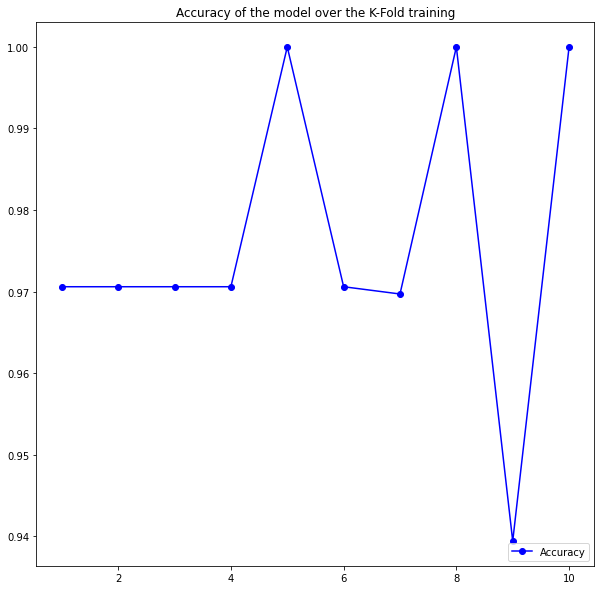

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, 11), VAL_ACCURACY, 'b-o', label='Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy of the model over the K-Fold training')

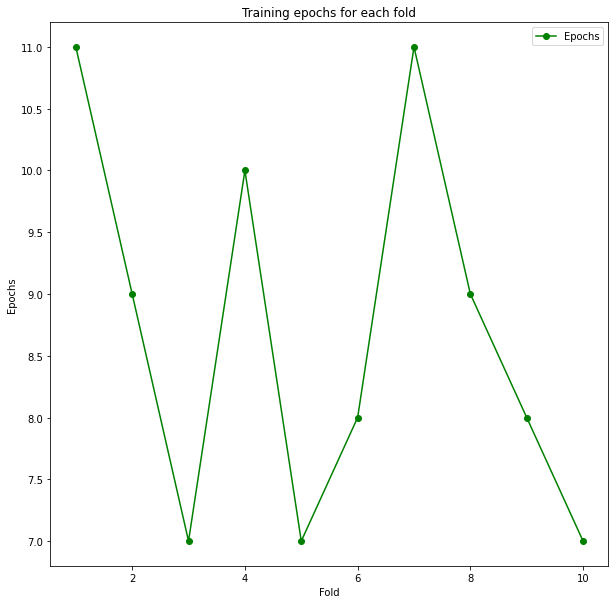

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, 11), EPOCHS, 'g-o', label='Epochs')
plt.legend(loc='upper right')
plt.title('Training epochs for each fold')
plt.xlabel('Fold')
plt.ylabel('Epochs')
plt.show()

Se eliminan los archivos generados.

In [ ]:
os.remove('products.csv')
shutil.rmtree('validation')

Se guarda el modelo en su respectiva carpeta

In [ ]:
%cd ..
%cd ..
%cd ..

/content/drive/.shortcut-targets-by-id/1-jD7WLMdUgZYVERC_Q9SBlSQEm5HyziM
/content/drive/.shortcut-targets-by-id
/content/drive


In [ ]:
%cd MyDrive/SKUs/Modelo\ Isra/model/JOE model

/content/drive/MyDrive/SKUs/Modelo Isra/model/JOE model


In [ ]:
#Cambiar basándose en la primera gráfica
model_2_save = MODELS[9]
model_2_save.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#Cambiar el nombre con base en el número de SKUs
model_2_save.save('JOE_model_21skus_new')